# Show "best fit" high-pressure limit kinetics 
Run this script once to identify a list of reactions including indices that produce the highest 
rates per reaction family for unimolecular and bimolecular reactions. Based on the result, 
improve the database and run the script again. Repeat this process until the "best fit" 
high-pressure limit kinetics show "reasonable" rates.

In [1]:
import os
import time
import operator
import unittest 
import numpy as np
from copy import deepcopy

from rmgpy import settings
from rmgpy.data.kinetics.database import KineticsDatabase
from rmgpy.data.base import DatabaseError
from rmgpy.molecule.molecule import Molecule
from rmgpy.species import Species
from rmgpy.data.rmg import RMGDatabase
from rmgpy.data.kinetics.common import KineticsError, saveEntry
from rmgpy.kinetics.arrhenius import Arrhenius
from rmgpy.data.rmg import getDB
from rmgpy.thermo.thermoengine import submit
from rmgpy.reaction import Reaction
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


## Step 1: 
Select the family to work on.

In [2]:
family = '1,2_Insertion_carbene'

In [3]:
#path = os.path.join(settings['database.directory'], 'kinetics','families')
database = RMGDatabase()
database.load(
    settings['database.directory'], 
    thermoLibraries = ['primaryThermoLibrary','Klippenstein_Glarborg2016','BurkeH2O2','thermo_DFT_CCSDTF12_BAC','CBS_QB3_1dHR', 'DFT_QCI_thermo'],
    transportLibraries = [],
    reactionLibraries = [],
    seedMechanisms = [],
    kineticsFamilies = [family],
    kineticsDepositories = ['training'],
    depository = False,  
)

In [4]:
#all_families = getDB('kinetics').families.keys()
#all_families = ['H_Abstraction']

# Discrete temperature range
Ts = np.linspace(300,2000,30)

In [5]:
def analyze_reactions(fam_name, molecularity=1, forward=True):
    print fam_name
    
    fam = database.kinetics.families[fam_name]
    dep = fam.getTrainingDepository()
    rxns = []
    list_indices = []

    # Extract all training reactions for selected family
    for entry in dep.entries.values():
        r = entry.item
        r.kinetics = entry.data
        r.index = entry.index
        for spc in r.reactants+r.products:
            if spc.thermo is None:
                submit(spc)
        rxns.append(r)

    # Only proceed if at least one training reaction is available
    if rxns:         
        # Get kinetic rates for unimolecular reactions
        k_list = []
        index_list = []
        for rxn in rxns:
            if forward:
                if len(rxn.reactants) == molecularity:
                    k_list.append(rxn.kinetics)
                    index_list.append(rxn.index)
            else:
                if len(rxn.products) == molecularity:
                    k_list.append(rxn.generateReverseRateCoefficient())
                    index_list.append(rxn.index)

        # Get max. kinetic rates at each discrete temperature
        if k_list:
            k_max_list = []
            rxn_indices = set()
            for T in Ts:
                mydict = {}
                kvals = [k.getRateCoefficient(T) for k in k_list]
                mydict = dict(zip(index_list, kvals))

                # Find key and value of max rate coefficient
                key_max_rate = max(mydict.iteritems(), key=operator.itemgetter(1))[0]
                rxn_indices.add(key_max_rate)
                kval = mydict[key_max_rate]
                k_max_list.append(kval)
                print """For {0} 1/K training reaction {1} with index {2} has the highest rate 
                of {3}.""".format(1000.0/T, dep.entries.get(key_max_rate), key_max_rate, kval)
                
                if molecularity == 2:
                    max_rxn = dep.entries.get(key_max_rate).item
                    display(max_rxn)
                    print "collision limit:  {}".format(max_rxn.calculate_coll_limit(T))
                    print "collision limit agrees?"
                    print [] == rxns[key_max_rate].check_collision_limit_violation( 300.0, 2000.0, 0.1, 100.0)


            units = 's^-1' if molecularity == 1 else 'm^3/(mol*s)'
                
            arr = Arrhenius().fitToData(Ts,np.array(k_max_list), units)

            fig = plt.figure()
            fig_name = fam_name
            fig_name += ' Unimolecular' if molecularity == 1 else ' Bimolecular'
            #save_path = 'ArrheniusFig/'
            plt.semilogy(1000.0/Ts, k_max_list, label=fig_name)
            plt.xlabel("1000/T (1/K)")
            plt.ylabel("k ({0})".format(units))
            plt.legend(loc='upper left')
            #fig.savefig((save_path + fig_name + '_Unimolecular' + '.png'), bbox_inches='tight')
            #plt.close("all")
            
            if not forward:
                spc_set = set()
                for rxn_ind in rxn_indices:
                    spc_set.update(rxns[rxn_ind].reactants)
                    spc_set.update(rxns[rxn_ind].products)
                for spcs in spc_set:
                    print spcs.thermo.comment


## Step 2a: unimolecular reactions - forward
Generate a list of reactions including indices that produce the highest rates per reaction family for unimolecular reactions.

In [6]:
analyze_reactions(family, molecularity=1, forward=True)

1,2_Insertion_carbene


/Users/mjliu/Code/RMG-Py/rmgpy/tools/plot.py:36: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/mjliu/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/mjliu/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/mjliu/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/mjliu/anaconda2/envs/rmg_env/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/mjliu/anaconda2/envs/rmg_env/lib/python2.7/site-

## Step 2a: unimolecular reactions - backward
Generate a list of reactions including indices that produce the highest rates per reaction family for unimolecular reactions.

1,2_Insertion_carbene
For 3.33333333333 1/K training reaction CH2 + CH3CCH_r2 <=> CH3CH2CCH with index 3 has the highest rate 
                of 1.75522892729e-62.
For 2.78846153846 1/K training reaction CH2 + CH3CHCH2_r3 <=> CH3CH2CHCH2 with index 6 has the highest rate 
                of 8.33245595103e-50.
For 2.39669421488 1/K training reaction CH2 + CH3CHCH2_r3 <=> CH3CH2CHCH2 with index 6 has the highest rate 
                of 1.11178825644e-40.
For 2.10144927536 1/K training reaction CH2 + CH3CHCH2_r3 <=> CH3CH2CHCH2 with index 6 has the highest rate 
                of 8.15163070621e-34.
For 1.87096774194 1/K training reaction CH2 + CH3CHCH2_r3 <=> CH3CH2CHCH2 with index 6 has the highest rate 
                of 1.82541100244e-28.
For 1.68604651163 1/K training reaction CH2 + CH3CHCH2_r3 <=> CH3CH2CHCH2 with index 6 has the highest rate 
                of 3.5198898145e-24.
For 1.53439153439 1/K training reaction CH2 + CH3CHCH2_r3 <=> CH3CH2CHCH2 with index 6 has the highes

/Users/mjliu/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/mjliu/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


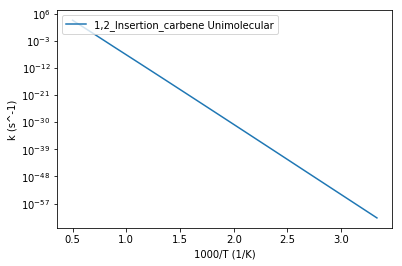

In [7]:
analyze_reactions(family, molecularity=1, forward=False)

## Step 2b: bimolecular reactions - forward 
Generate a list of reactions including indices that produce the highest rates per reaction family for bimolecular reactions.

1,2_Insertion_carbene
For 3.33333333333 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 116382243.665.


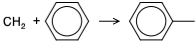

collision limit:  118190423.509
collision limit agrees?
True
For 2.78846153846 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 78180075.7694.


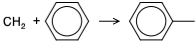

collision limit:  125837444.499
collision limit agrees?
True
For 2.39669421488 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 58362392.4532.


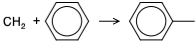

collision limit:  132710703.305
collision limit agrees?
True
For 2.10144927536 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 46601462.6868.


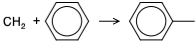

collision limit:  138982679.824
collision limit agrees?
True
For 1.87096774194 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 38949711.543.


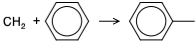

collision limit:  144771367.55
collision limit agrees?
True
For 1.68604651163 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 33629757.7345.


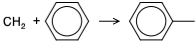

collision limit:  150161459.253
collision limit agrees?
True
For 1.53439153439 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 29741651.7639.


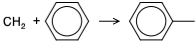

collision limit:  155216085.178
collision limit agrees?
True
For 1.40776699029 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 26787684.083.


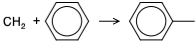

collision limit:  159983708.793
collision limit agrees?
True
For 1.30044843049 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 24473032.4959.


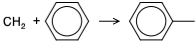

collision limit:  164502431.629
collision limit agrees?
True
For 1.20833333333 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 22613196.5527.


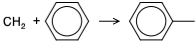

collision limit:  168802841.246
collision limit agrees?
True
For 1.12840466926 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 21087414.6983.


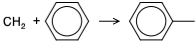

collision limit:  172909903.036
collision limit agrees?
True
For 1.05839416058 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 19813637.2061.


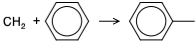

collision limit:  176844279.992
collision limit agrees?
True
For 0.996563573883 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 18734330.8688.


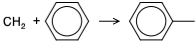

collision limit:  180623316.238
collision limit agrees?
True
For 0.941558441558 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 17808051.0368.


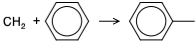

collision limit:  184261703.313
collision limit agrees?
True
For 0.892307692308 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 17004238.7143.


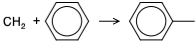

collision limit:  187772034.252
collision limit agrees?
True
For 0.847953216374 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 16299898.5037.


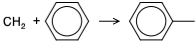

collision limit:  191165167.087
collision limit agrees?
True
For 0.807799442897 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                of 15677414.1751.


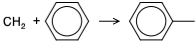

collision limit:  194450574.977
collision limit agrees?
True
For 0.771276595745 1/K training reaction CH2 + CH2CCH2 <=> CH3CHCCH2 with index 7 has the highest rate 
                of 15425340.6242.


collision limit:  163780267.154
collision limit agrees?
True
For 0.737913486005 1/K training reaction CH2 + CH2CCH2 <=> CH3CHCCH2 with index 7 has the highest rate 
                of 15291969.4772.


collision limit:  166344103.346
collision limit agrees?
True
For 0.707317073171 1/K training reaction CH2 + CH2CCH2 <=> CH3CHCCH2 with index 7 has the highest rate 
                of 15183334.1147.


collision limit:  168836968.21
collision limit agrees?
True
For 0.679156908665 1/K training reaction CH2 + CH2CCH2 <=> CH3CHCCH2 with index 7 has the highest rate 
                of 15095617.4067.


collision limit:  171263646.559
collision limit agrees?
True
For 0.653153153153 1/K training reaction CH2 + CH3CCCH3_r1 <=> CH3CH2CCCH3 with index 10 has the highest rate 
                of 15042000.6245.


collision limit:  189514144.356
collision limit agrees?
True
For 0.629067245119 1/K training reaction CH2 + CH3CCCH3_r1 <=> CH3CH2CCCH3 with index 10 has the highest rate 
                of 15280277.4865.


collision limit:  192031943.731
collision limit agrees?
True
For 0.606694560669 1/K training reaction CH2 + CH3CCCH3_r1 <=> CH3CH2CCCH3 with index 10 has the highest rate 
                of 15521204.8464.


collision limit:  194490206.448
collision limit agrees?
True
For 0.585858585859 1/K training reaction CH2 + CH3CCCH3_r1 <=> CH3CH2CCCH3 with index 10 has the highest rate 
                of 15764340.6559.


collision limit:  196892385.07
collision limit agrees?
True
For 0.56640625 1/K training reaction CH2 + CH3CCCH3_r1 <=> CH3CH2CCCH3 with index 10 has the highest rate 
                of 16009313.1603.


collision limit:  199241616.556
collision limit agrees?
True
For 0.54820415879 1/K training reaction CH2 + CH3CCCH3_r1 <=> CH3CH2CCCH3 with index 10 has the highest rate 
                of 16255808.0767.


collision limit:  201540778.994
collision limit agrees?
True
For 0.531135531136 1/K training reaction CH2 + CH3CCCH3_r1 <=> CH3CH2CCCH3 with index 10 has the highest rate 
                of 16503558.4386.


collision limit:  203792494.006
collision limit agrees?
True
For 0.515097690941 1/K training reaction CH2 + CH3CCCH3_r1 <=> CH3CH2CCCH3 with index 10 has the highest rate 
                of 16752336.4871.


collision limit:  205999169.078
collision limit agrees?
True
For 0.5 1/K training reaction CH2 + CH3CCCH3_r1 <=> CH3CH2CCCH3 with index 10 has the highest rate 
                of 17001947.1453.


collision limit:  208163034.317
collision limit agrees?
True


/Users/mjliu/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


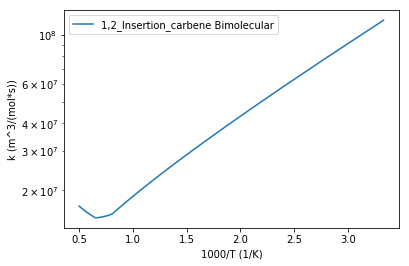

In [8]:
analyze_reactions(family, molecularity=2, forward=True)

## Step 2b: bimolecular reactions - backward
Generate a list of reactions including indices that produce the highest rates per reaction family for bimolecular reactions.

In [9]:
analyze_reactions(family, molecularity=2, forward=False)

1,2_Insertion_carbene
